# IAI 5101

# Voice Gender Detection



In [ ]:
#clone the dataset repo
#please clone only once if necessay
%cd /content/
#http://emodb.bilderbar.info/index-1280.html
!git clone https://dagshub.com/kingabzpro/voice_gender_detection.git









/content
fatal: destination path 'voice_gender_detection' already exists and is not an empty directory.


In [ ]:
%cd ./voice_gender_detection
#view dirctory

%ls -R
#only run if ./males and ./females do not exist already

!pip install dvc
!dvc remote list
!dvc remote default origin


/content/voice_gender_detection
.:
females/  females.dvc  fileconvert.py  LICENSE  males/  males.dvc  README.md

./females:
0.wav     1209.wav  1418.wav  1627.wav  1837.wav  2045.wav  2254.wav  382.wav  591.wav  7.wav
1000.wav  120.wav   1419.wav  1628.wav  1838.wav  2046.wav  2255.wav  383.wav  592.wav  800.wav
1001.wav  1210.wav  141.wav   1629.wav  1839.wav  2047.wav  2256.wav  384.wav  593.wav  801.wav
1002.wav  1211.wav  1420.wav  162.wav   183.wav   2048.wav  2257.wav  385.wav  594.wav  802.wav
1003.wav  1212.wav  1421.wav  1630.wav  1840.wav  2049.wav  2258.wav  386.wav  595.wav  803.wav
1004.wav  1213.wav  1422.wav  1631.wav  1841.wav  204.wav   2259.wav  387.wav  596.wav  804.wav
1005.wav  1214.wav  1423.wav  1632.wav  1842.wav  2050.wav  225.wav   388.wav  597.wav  805.wav
1006.wav  1215.wav  1424.wav  1633.wav  1843.wav  2051.wav  2260.wav  389.wav  598.wav  806.wav
1007.wav  1216.wav  1425.wav  1634.wav  1844.wav  2052.wav  2261.wav  38.wav   599.wav  807.wav
1008.wav  1217

In [ ]:
!dvc pull females.dvc
!dvc pull males.dvc

Fetching
!
  0% |          |0/? [00:00<?,    ?files/s]
Fetching
Building workspace index          |2.31k [00:00, 4.45kentry/s]
Comparing indexes          |2.31k [00:00, 17.8kentry/s]
Applying changes          |0.00 [00:00,     ?file/s]
Everything is up to date.
Fetching
!
  0% |          |0/? [00:00<?,    ?files/s]
Fetching
Building workspace index          |3.68k [00:00, 3.83kentry/s]
Comparing indexes          |3.68k [00:00, 24.7kentry/s]
Applying changes          |0.00 [00:00,     ?file/s]
Everything is up to date.


In [ ]:
import os # for reading files & pathes
import torchaudio
import torch.nn as nn
import torch
import numpy as np
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import seaborn as sns


# the main components

SAMPLE_RATE = 16000
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001


Data = '/content/voice_gender_detection'
TestData = '/content/TestData'

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import torchaudio

class AudioDataset(Dataset):
    def __init__(self, root_dir, target_sample_rate, transform , device ):
        """
        Args:
            root_dir (string): Directory with all the audio folders ('Male' and 'Female').
            target_sample_rate (int): Target sample rate for all audio files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.target_sample_rate = target_sample_rate
        self.duration = 4  # Duration in seconds
        self.num_samples = self.target_sample_rate * self.duration
        self.device = device
        self.transform = transform.to(self.device)
        self.samples = []
        self.class_names = ['males', 'females']

        class_counts = {class_name: 0 for class_name in self.class_names}

        for class_name in self.class_names:
          class_dir = os.path.join(self.root_dir, class_name)
          class_counts[class_name] = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])

        min_count = min(class_counts.values())
        # Load dataset
        for index, class_name in enumerate(self.class_names):
          class_dir = os.path.join(self.root_dir, class_name)
          loaded_samples = 0  # Track number of loaded samples for this class
          for wav_file in os.listdir(class_dir):
            if loaded_samples < min_count:  # Only add up to min_count instances per class
              self.samples.append({
                      'audio_path': os.path.join(class_dir, wav_file),
                      'label': index  # 0 for Male, 1 for Female
                  })
              loaded_samples += 1
            else:
              break

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._ensure_fixed_length(signal)
        if self.transform:
            signal = self.transform(signal)
        return signal, label

    def _get_audio_sample_path(self, index):
        return self.samples[index]['audio_path']

    def _get_audio_sample_label(self, index):
        return self.samples[index]['label']

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:  # More than one channel
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _ensure_fixed_length(self, signal):
        # Cut if necessary
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        # Right pad if necessary
        elif signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    def get_class_distribution(self):
        # Initialize a dictionary to hold the count of each class
        class_distribution = {class_name: 0 for class_name in self.class_names}
        # Loop through all samples and increment the count for each class
        for sample in self.samples:
            label = sample['label']  # 0 for 'Male', 1 for 'Female'
            class_name = self.class_names[label]
            class_distribution[class_name] += 1
        return class_distribution


In [ ]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
if torch.cuda.is_available():
        device = "cuda"
else:
        device = "cpu"
print(f"Using device {device}")
dataset = AudioDataset(root_dir=Data, target_sample_rate = SAMPLE_RATE, transform=mel_spectrogram , device = device)
# traildataset = AudioDataset(root_dir=TestData, target_sample_rate = SAMPLE_RATE, transform=mel_spectrogram , device = device)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(f"There are {(len(train_dataset))} samples in the dataset.")
print(f"There is {dataset.get_class_distribution()}")


Using device cpu
There are 3235 samples in the dataset.
There is {'males': 2311, 'females': 2311}


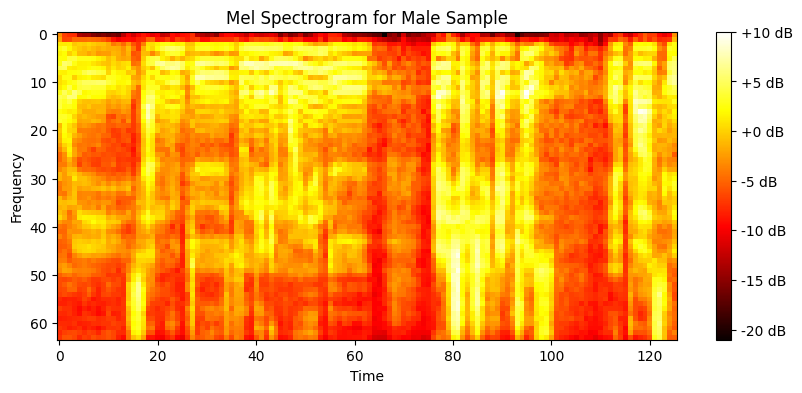

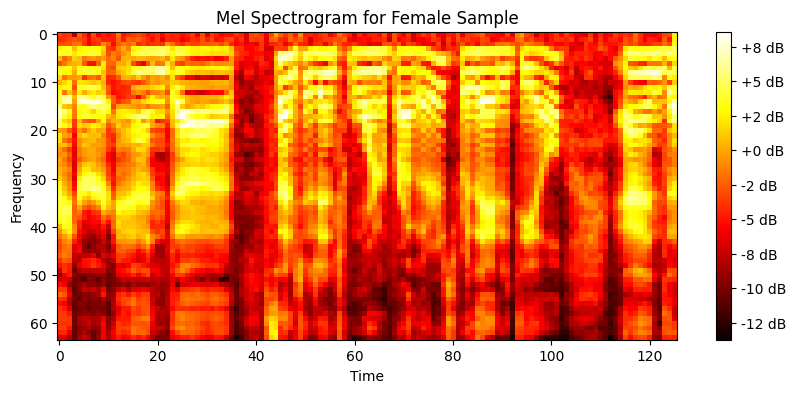

In [ ]:
# Function to visualize Mel Spectrogram
def visualize_mel_spectrogram(samples, title):
    plt.figure(figsize=(10, 4))
    for signal in samples:
        # Convert to Mel Spectrogram and visualize
        plt.imshow(signal.log2().cpu().numpy(), cmap='hot', aspect='auto')
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.colorbar(format='%+2.0f dB')
        plt.show()

# Visualize Mel Spectrograms for the found samples

visualize_mel_spectrogram(dataset[0][0], 'Mel Spectrogram for Male Sample')

visualize_mel_spectrogram(dataset[3000][0], 'Mel Spectrogram for Female Sample')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioClassifierCNN(nn.Module):
    def __init__(self):
        super(AudioClassifierCNN, self).__init__()
        # Adjusting for input spectrogram size of (64, 126)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling reduces size by half
        self.dropout1 = nn.Dropout(0.6)  # Dropout layer after first conv block

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.6)  # Dropout layer after second conv block

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.6)  # Dropout layer after third conv block

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.6)  # Dropout layer after fourth conv block

        # After passing through four pooling layers:
        # Height dimension: 64 / 2^4 = 4
        # Width dimension: 126 / 2^4 = 7.875, which is practically considered as 7 (since dimensions are integer)
        self.fc1 = nn.Linear(128 * 4 * 7, 512)  # Adjusting based on the convolution and pooling layers' output
        self.fc2 = nn.Linear(512, 2)  # Final output layer

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)  # Apply dropout after first conv block
        x = self.pool(x)  # Apply pooling after dropout

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)  # Apply dropout after second conv block
        x = self.pool(x)  # Apply pooling after dropout

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)  # Apply dropout after third conv block
        x = self.pool(x)  # Apply pooling after dropout

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout4(x)  # Apply dropout after fourth conv block
        x = self.pool(x)  # Apply pooling after dropout

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 128 * 4 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
from torch.utils.data import DataLoader
import torch
def create_data_loader(train_data, batch_size,shuffle):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Seaborn's heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def run_epoch(model, data_loader, loss_fn, optimizer, device, is_train):
    if is_train:
        model.train()
    else:
        model.eval()

    correct = 0
    total = 0
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.set_grad_enabled(is_train):
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            # Save predictions and targets for calculating additional metrics
            all_predictions.extend(predicted.view(-1).cpu().numpy())
            all_targets.extend(targets.view(-1).cpu().numpy())

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # Calculate additional metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    confusion = confusion_matrix(all_targets, all_predictions)

    epoch_loss = total_loss / len(data_loader)
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy, precision, recall, f1, confusion


import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # Additional metrics
    train_precisions = []
    train_recalls = []
    train_f1s = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training phase
        train_loss, train_accuracy, train_precision, train_recall, train_f1, _ = run_epoch(
            model, train_loader, loss_fn, optimizer, device, is_train=True)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        # Validation phase
        val_loss, val_accuracy, val_precision, val_recall, val_f1, val_confusion = run_epoch(
            model, val_loader, loss_fn, optimizer, device, is_train=False)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # Log the metrics
        print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        print("---------------------------")

    print("Finished training")

    # Plotting training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

    class_names = ['Males', 'Females']
    plot_confusion_matrix(val_confusion, class_names)


AudioClassifierCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.6, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.6, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.6, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.6, inplace=False)
  (fc1): Linear(in_features=3584, out_features=512, bi

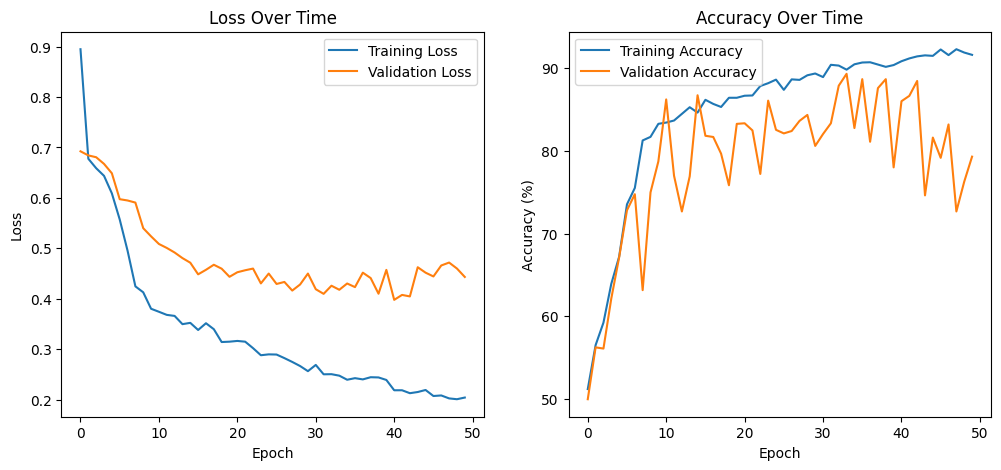

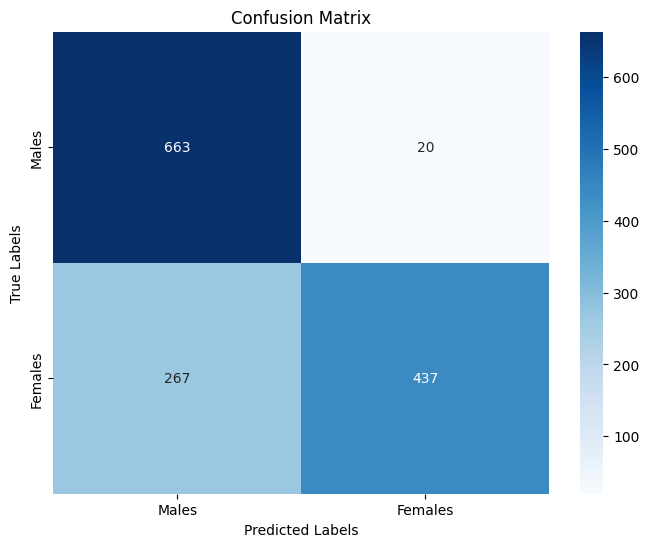

Trained feed forward net saved at feedforwardnet.pth


In [ ]:
train_loader = create_data_loader(train_dataset,BATCH_SIZE , True)
val_loader = create_data_loader(val_dataset,BATCH_SIZE , False)
    # construct model and assign it to device
cnn = AudioClassifierCNN().to(device)
print(cnn)

    # initialise loss funtion + optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=LEARNING_RATE)

    # train model
train(cnn, train_loader,val_loader, loss_fn, optimiser, device, EPOCHS)

    # save model
torch.save(cnn.state_dict(), "feedforwardnet.pth")
print("Trained feed forward net saved at feedforwardnet.pth")

In [ ]:
class_mapping = [
 "Male",
 "Female"
]

def predict(model, input, target, class_mapping):
    #model = model.to(torch.device('cuda'))
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected



In [ ]:
cnn = AudioClassifierCNN()
state_dict = torch.load("/content/voice_gender_detection/feedforwardnet.pth")
cnn.load_state_dict(state_dict)
inputs, targets = traildataset[8][0], traildataset[8][1] # [batch size, num_channels, fr, time]
inputs.unsqueeze_(0)
    # make an inference
predicted, expected = predict(cnn, inputs, targets,
                                  class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'Male', expected: 'Female'
